## Deep Learning for images

In the last chapter, we have learned how to create a simple neural network with multiple layers and activation functions. Our inputs were always simple lists of numbers as those found in simple relations like $y = f(x_0, x_1, \ldots) = w_0*x_0 + w_1 * x_1 \ldots$. There are however many types of data that don't come in the form of a simple list of numbers and images (natural, satellite, medical images etc.) are one of the most important example of such data. Images processing is actually one of the main domains where Deep Learning has quickly emerged as a revolutionary technique allows these days for self-driving cars, assisted surgery etc. In this chapter we will explore one example of an image specific layer type, the convolutional layer, and see a few examples of applications for classification, segmentation, generation etc.

## Local information

When we use a linear layer, each node is connected to all other nodes as shown below:

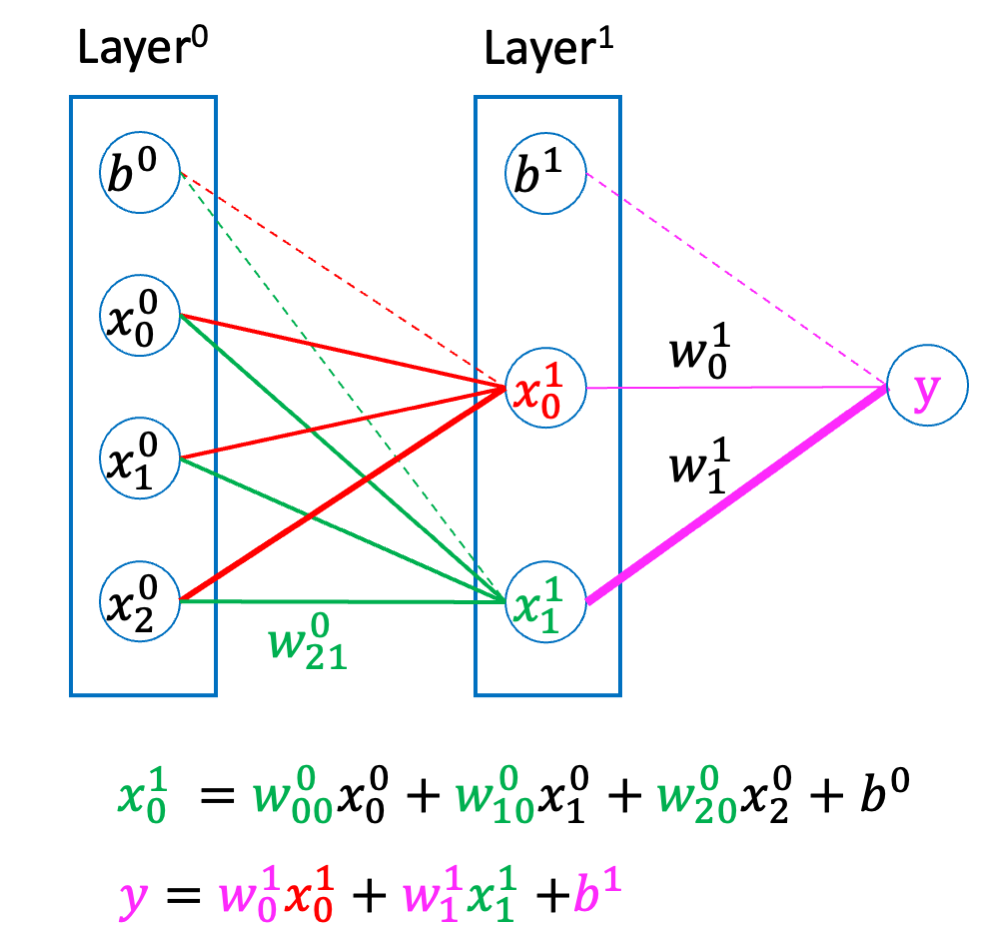

In [1]:
from IPython.display import Image, display
Image('images/networks/networks3.png', width=500)

This means that all nodes are equivalent to each other: **there is no a priori relation between neighboring nodes**. Now let's look at what an image actually is. For this we will use a dataset coming directly from PyTorch and called MNIST that contains hand-drawn numbers:

In [2]:
from torchvision.datasets import MNIST

In [3]:
mnist = MNIST(root = '/Users/gw18g940/Desktop/Test_data_courses/BFH/', download=True)

We can access the actual images using ```mnist.data``` which is a Numpy array containing all images. It has these dimensions:

In [4]:
mnist.data.shape

torch.Size([60000, 28, 28])

We have 60000 images of 28x28 pixels. We can just have a look at the values inside the first image:

In [5]:
mnist.data[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

What we see above is the value of each individual pixel of the image: an image is just a list of values! We can already see some patterns in the pixel list above, but the common way to represent such a list of pixels is as an image, i.e. a color gets assigned to each pixel value and we show the results as a grid of colored squares. We can plot such an image using Matplotlib's ```imshow``` function (we added a grid for pixel visibility):

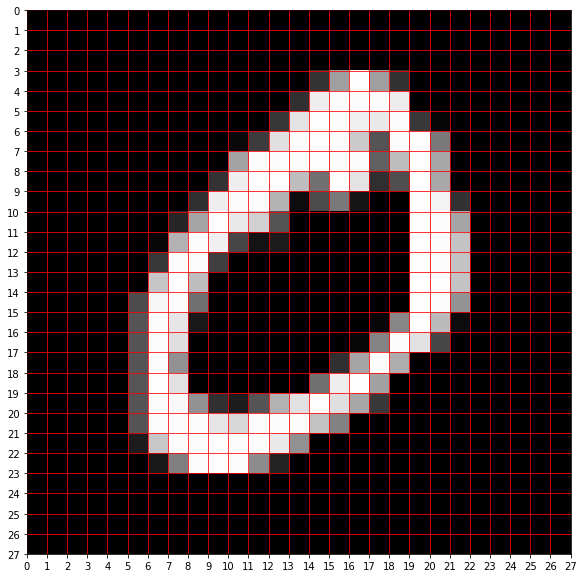

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(mnist.data[1], cmap='gray');
ax.grid(visible=True, color='red')
ax.set_xticks(np.arange(0.5,28.5), labels=np.arange(0,28));
ax.set_yticks(np.arange(0.5,28.5), labels=np.arange(0,28));
ax.set_xlim(0.5,27.5)
ax.set_ylim(27.5, 0.5);

As the image is small, we can already see individual pixels and we also see that we have indeed 28 columns and 28 rows. If we wanted to re-use the sort of network depicted above, we would now need to "flatten" this image, i.e. forget that an image is a 2D object and just create one long list of numbers (28x28 = 784 numbers). Then each of these number becomes an equivalent input in our network:

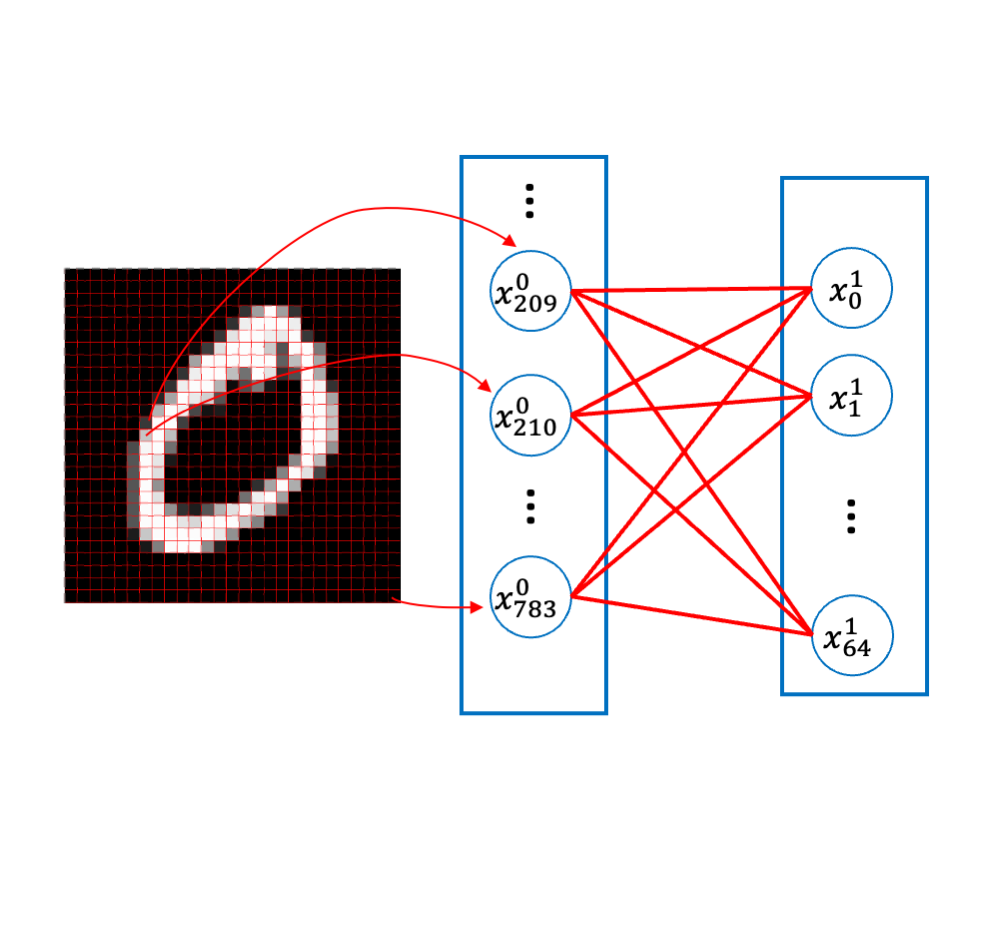

In [8]:
Image('images/networks/networks6.png', width=500)

As we can see above, each node of the second layer is connected to all pixels in *the exact same way*, i.e. the location of the pixel in the image doesn't count at all: the two neighboring pixels belonging to foreground (the number) are equivalent to he lower-right background pixel. Does that make sense? Clearly if we look at the image or at the grid of numbers that the image is, we can see for example that if a pixel has a large value (it belongs to the number) its neighbors have also a higher chance of having a large value. Similarly, most background pixels have background neighbors. When we proceed as described above, we completely loose all this information about the **correlations** in the image, and most of the connections are meaningless!

## Convolutions

The solution to this problem is to capture **local information**. Instead of considering all pixels as equivalent we make small groups of pixels to consider together. Given that an image contains local information, e.g. if there's a car in a picture all its pixels are close together, it make sense to group pixel by their location as shown below where only squares of 2x2 pixels are considered together. For each 2x2 pixel region we obtain a new value using the same linear combination as used before $x_{6,7}^{\texttt{new}} = w_{0,0}*x^0_{14,7} + w_{0,1}*x^0_{14,8} + w_{1,0}*x^0_{15,7}+ w_{1,1}*x^0_{15,8}$.

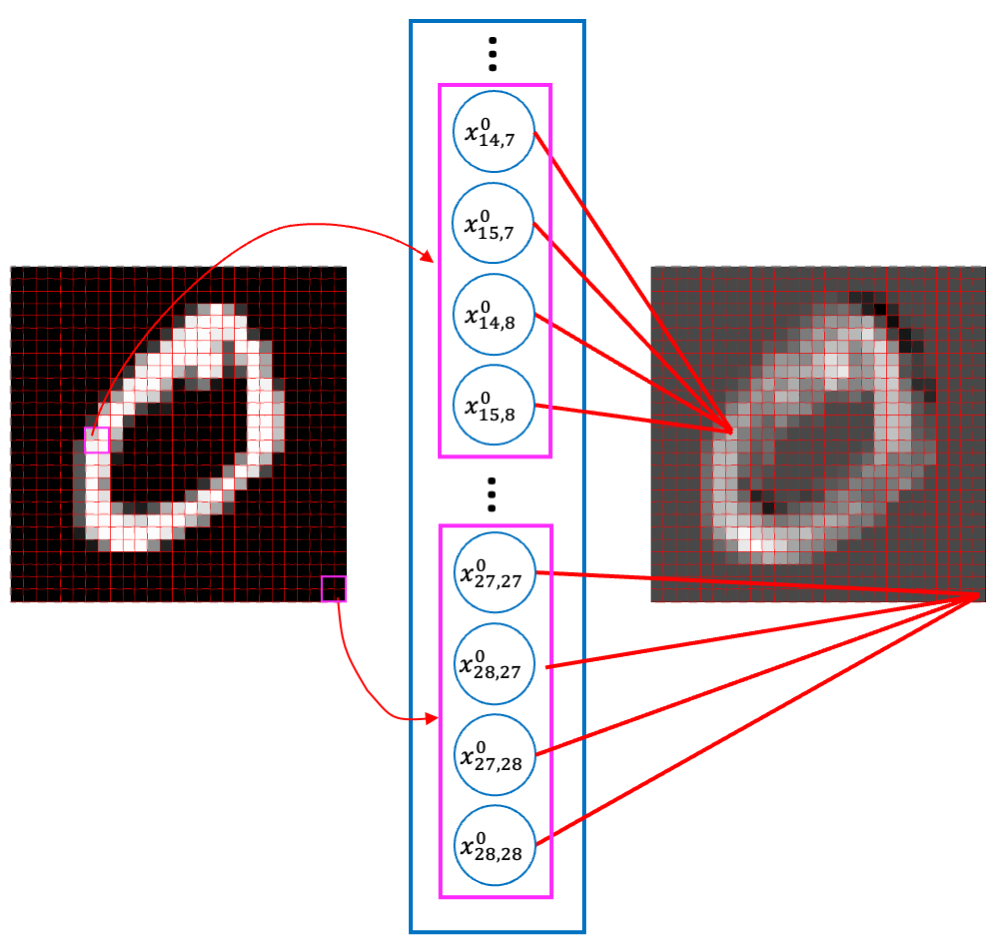

In [41]:
Image('images/networks/networks7.png', width=500)

As we can see above, the result of this operation is a new **filtered** image. As in the linear network, the weights $w_i$ are initialized randomly and then adjusted during training. The output seen above is just the filtering of the image with a random filter. Note that the **same weights** $w_i$ are used for the entire picture. However we can run the filtering several times with different filters, and obtain each time a different filtered image. This is what is done in Deep Learning: in a given **convolutional layer**, we train multiple sets of weights to obtain a series of filtered images called channels. This is what is achieved with the ```Conv2d``` layer from PyTorch. We specify how many input channels ```in_channels``` we have, in this case just our single channel image, and how many output channels ```out_channels``` we want, i.e. with how many different filters we want to filter the image. We also specify how big a region the filter should cover ```kernel_size```. In our example above we used 2x2 pixels, but we can use whatever size, 3x3, 4x4 etc.

Here we want 4 output channels and use a filter of size 3:

In [9]:
from torch import nn
import torch

In [10]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)

In [13]:
im_convolved = conv_layer(mnist.data[1].float().unsqueeze(0))

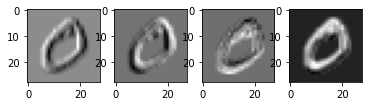

In [14]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(im_convolved[i].detach().numpy(), cmap='gray')

As weights in our filters are initialized randomly, each output looks different as it passed through a different filter.

### Stacking convolutions

Just like in the linear case we used all the outputs of a given layer as inputs to the next one, we can use all outputs of our convolutional layer (here 4 images) as input for the next layer. In this case we have to adjust the ```in_channels``` to reflect that we don't have a single image as input. Now instead of just considering the 2x2 pixels, we consider 2x2x4 pixels, i.e. the same group of pixels in each input image.

In [15]:
conv_layer2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1)
im_convolved2 = conv_layer2(im_convolved)

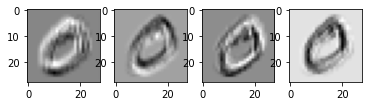

In [16]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(im_convolved2[i].detach().numpy(), cmap='gray')

## Downscaling

In order to capture features of increasing scale, another very common operation is simply to downscale the image, i.e. reduce the number of pixels. Here again there is a PyTorch layer that does it for us for example by local averaging (reducing e.g. 2x2 pixel to a single average value):

In [17]:
avgpool_layer = nn.AvgPool2d(kernel_size=3)
im_avg_pool = avgpool_layer(mnist.data[1].float().unsqueeze(0))

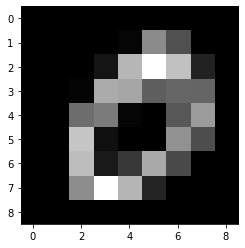

In [18]:
plt.imshow(im_avg_pool[0].detach().numpy(), cmap='gray');

Depending on the application, one might need an output of the same size as the input image. This is for example the case in segmentation where one wants to know for each input pixel to what category it belong (e.g. background or car). In such a case, one will probably also need to upscale the image in the network architecture, and this can naturally be done e.g. with the ```nn.Upsample``` layer.

## Activations

We have seen in the introduction to DL that having linear layers is not sufficient to learn complex models: we also need to add non-linearities in the system. Those are added as **activation layer** that essentially take the output of a layer and transform via a non-linear function (e.g. ReLU). The same has to be done for image processing networks and such layers are used in the same way: after filtering of an image, each pixel passes through the activation function so that the entire filtered image is "activated".

## Other layers

Convolutions and downscaling are some of the most important types of DL layers for image processing that are found in popular architecture. Of course there are many others that we can cover in this short introduction. For example recurrent layers, batch normalization, transpose convolution etc. The important concept is just to remember is that in image architecture such layers usually take images as input and give images as output.



## Composing a network

Now that we know a few layers we an create a neural network by assembling them in the same way we did for linear layers. For example we can start with a convolutional layer, add an activation, downscale the image and use again a convolution layer that generate a single channel image. Such a network is represented below:

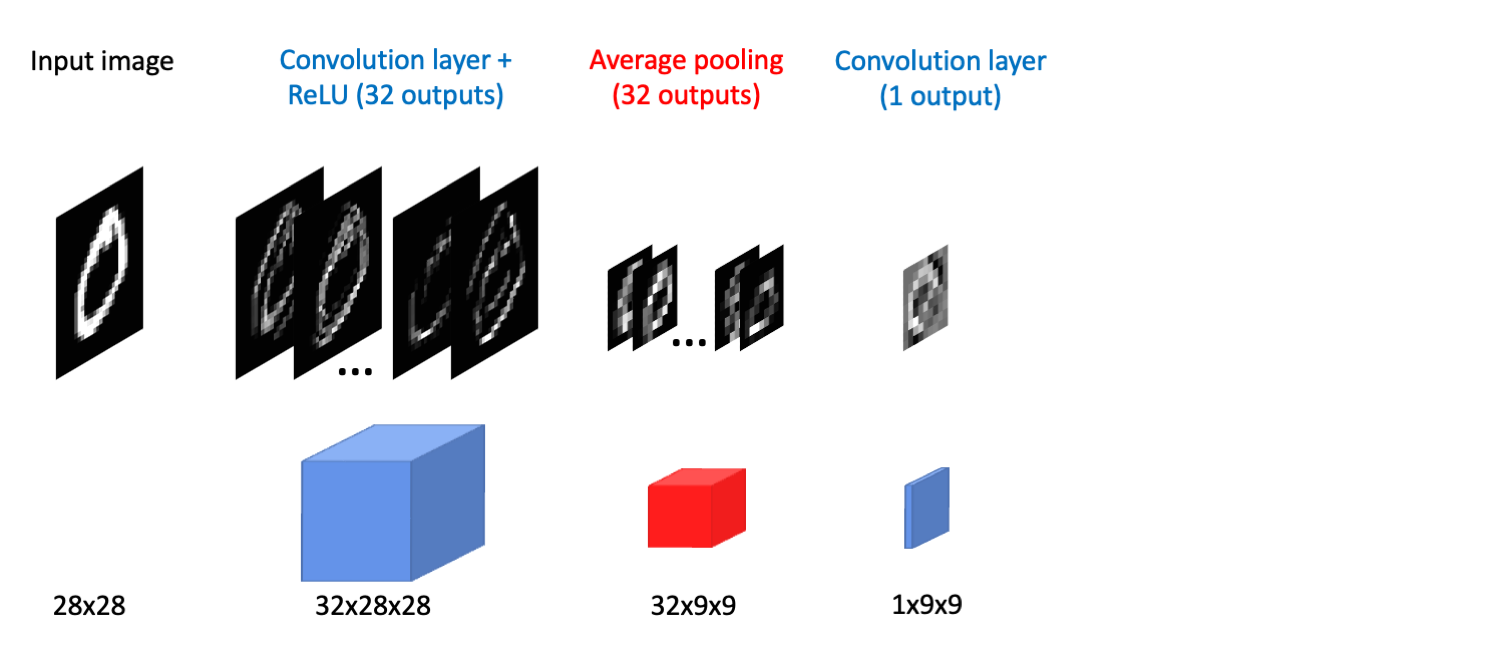

In [19]:
Image('images/conv_network_notask.png', width=900)

Networks are usually represented in a simplified form, each layer being shown as a box with certain dimensions as shown in the last row in the above drawing.  Let's implement this network: 

In [20]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
avgpool_layer = nn.AvgPool2d(kernel_size=3)
conv_layer2 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

model = nn.Sequential(
    conv_layer,
    nn.ReLU(),
    avgpool_layer,
    conv_layer2)

In [21]:
output = model(mnist.data[1].float().unsqueeze(0))

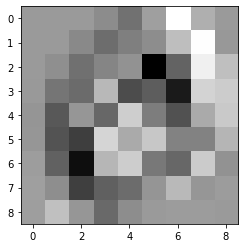

In [22]:
plt.imshow(output[0].detach().numpy(), cmap='gray');

Currently this is our output, but how can we use it?

## Image classification

The type of convolutional network described above can be used to "summarize" the image. Indeed, it learns local features in the image and combines them by looking at increasingly larger scales in the image to get the "big picture". Once we have the resulting 81 pixels shown above (9x9 image) we could use each pixel as a **feature** for a classifier. So at this point we can forget about the fact that we deal with an image and flatten the output into a list of numbers. Then we can use our list of features to predict a certain class using a fully connected layer (the same linear layers we used previously). For example we can restrict our data to zeros and ones and predict the probabilities that an image shown either of these numbers:

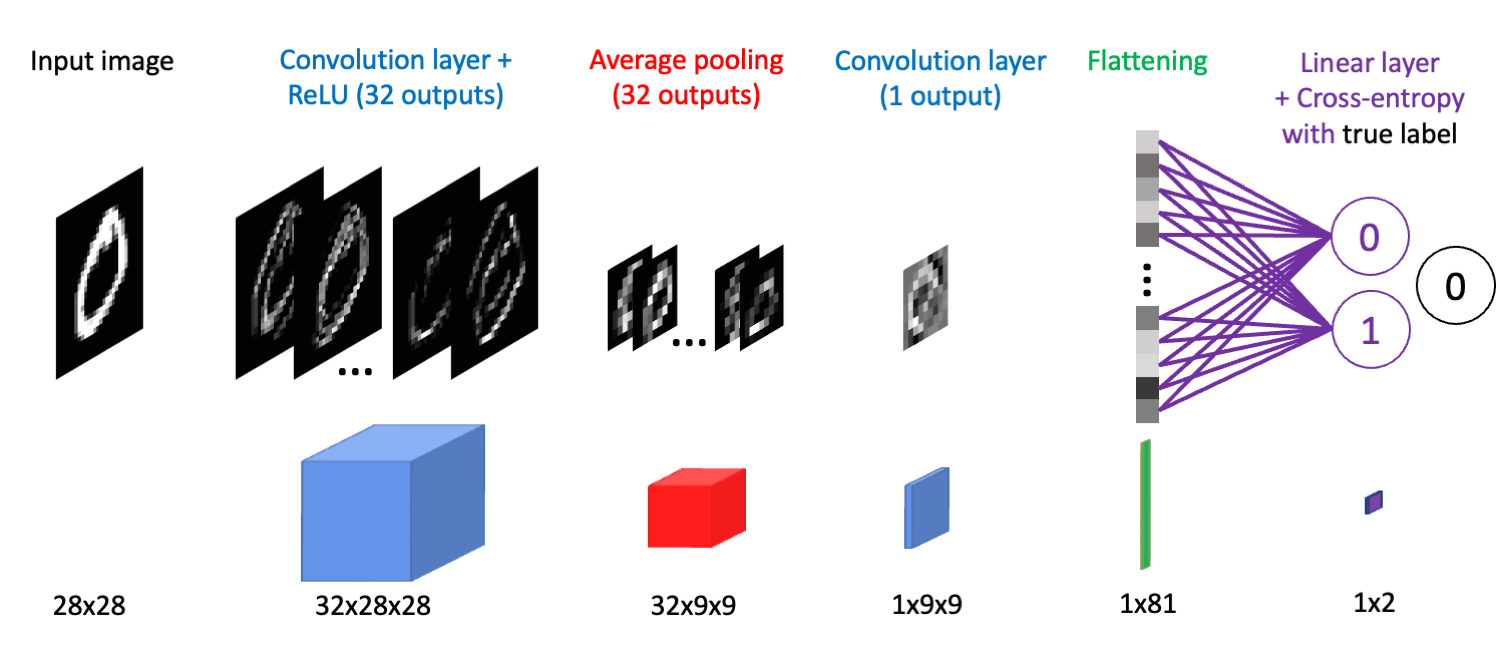

In [23]:
Image('images/conv_network_classifier.png', width=900)

Let's complete our network with the necessary layer. First a flattening layer:

In [24]:
model = nn.Sequential(
    conv_layer,
    nn.ReLU(),
    avgpool_layer,
    conv_layer2,
    nn.Flatten())

In [25]:
output = model(mnist.data[1].float().unsqueeze(0))
output.shape

torch.Size([1, 81])

The shape is correct now (the first dimension is used for the batch size, i.e. if we use multiple images. Now we need to use these 81 features to predict a category. As shown above we start with a simple case and try to distinguish zeros and ones. So the output should be two numbers that give us the probability of each category. We can use a linear layer with 81 input features and 2 output features:

In [96]:
#del model

In [97]:
model = nn.Sequential(
    conv_layer,
    nn.ReLU(),
    avgpool_layer,
    conv_layer2,
    nn.Flatten(),
    nn.Linear(in_features=81, out_features=2)
)

In [98]:
output = model(mnist.data[1].float().unsqueeze(0))
output.shape

torch.Size([1, 2])

As the for the regression example of the previous chapter we need now a metric that is then used to optimize the model weights. We can't use the MSE as we want to predict categories. We have to resort to another type of metric called cross-entropy (related to the entropy that we have seen when learning about classification trees). We will also need an optimizer to train our network.

In [99]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Training

Now we can write a training loop. At each iteration a few images go through the network and are each summarized into two numbers: the probabilities that the image shows a zero or a one. We compare the results to the true category and then use back-propagation to slightly adjust the filters to reach a better result. First we prepare train and test datasets with a hundred examples:

In [100]:
pick_number = [3,8]
train_data = mnist.data[(mnist.targets == pick_number[0]) | (mnist.targets == pick_number[1])][0:100]
train_labels = mnist.targets[(mnist.targets == pick_number[0]) | (mnist.targets == pick_number[1])][0:100]
train_labels[train_labels == pick_number[0]] = 0
train_labels[train_labels == pick_number[1]] = 1

test_data = mnist.data[(mnist.targets == pick_number[0]) | (mnist.targets == pick_number[1])][200:300]
test_labels = mnist.targets[(mnist.targets == pick_number[0]) | (mnist.targets == pick_number[1])][200:300]
test_labels[test_labels == pick_number[0]] = 0
test_labels[test_labels == pick_number[1]] = 1

Then we run our training loop (identical to previous chapter). We record at each batch (once all examples have been seen) the accuracy of the test sample. For that we compare the predicted label and the actual label:

In [101]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

accuracy_test = []
for j in range(20):
    for i in range(10):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs = train_data[i*10:(i+1)*10].float()
        inputs = inputs[:, np.newaxis]
        targets = train_labels[i*10:(i+1)*10]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        accuracy_test.append(torch.sum(torch.abs(model(test_data[:,np.newaxis].float()).argmax(axis=1)-test_labels)) / 100)

Here is the evolution of the acccuracy. We see that it initially goes steeply down as weights improve massively over the random start and then the improvement is slower:

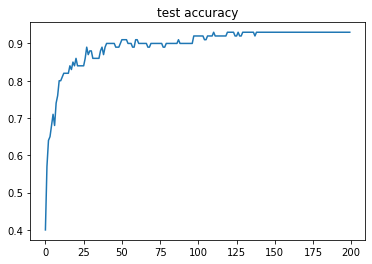

In [102]:
fig, ax = plt.subplots()
ax.plot(1-torch.stack(accuracy_test).numpy());
ax.set_title('test accuracy');

## Other usages

Often the main part of the network (including its training) can be kept and only the input and the output parts are changes. For example we might change the input to accommodate other types of images (gray scale vs RGB) or we might change the last part to change the task. Segmentation is a good example of this.
 
### Segmentation

The most common other usage of deep learning in imaging is segmentation, i.e. the detection of objects in an image. There are different types of segmentations. For example one can just determine boxes surrounding items (e.g. cars, people etc.), or one can precisely assign a category to each pixel in an image, in which case we obtain the precise outline of objects of interest.

Currently our networks just outputs two numbers to classify images, so we have to drop the flattening part and the classifier and replace it with something else. The last image that we obtain is smaller than the original, so the first thing to do is the **upscale** the image. This is now our output, and we have to compare it to some segmented image, i.e. an image where we know for each pixel to what category it belongs. In our MNIST example, this is simple, as we just have foreground and background. Finally we compare the output image and the segmented image and compute again some metric, for example cross entropy but this time **at the pixel** level: instead of classifying the entire picture, we classify each pixel individually!

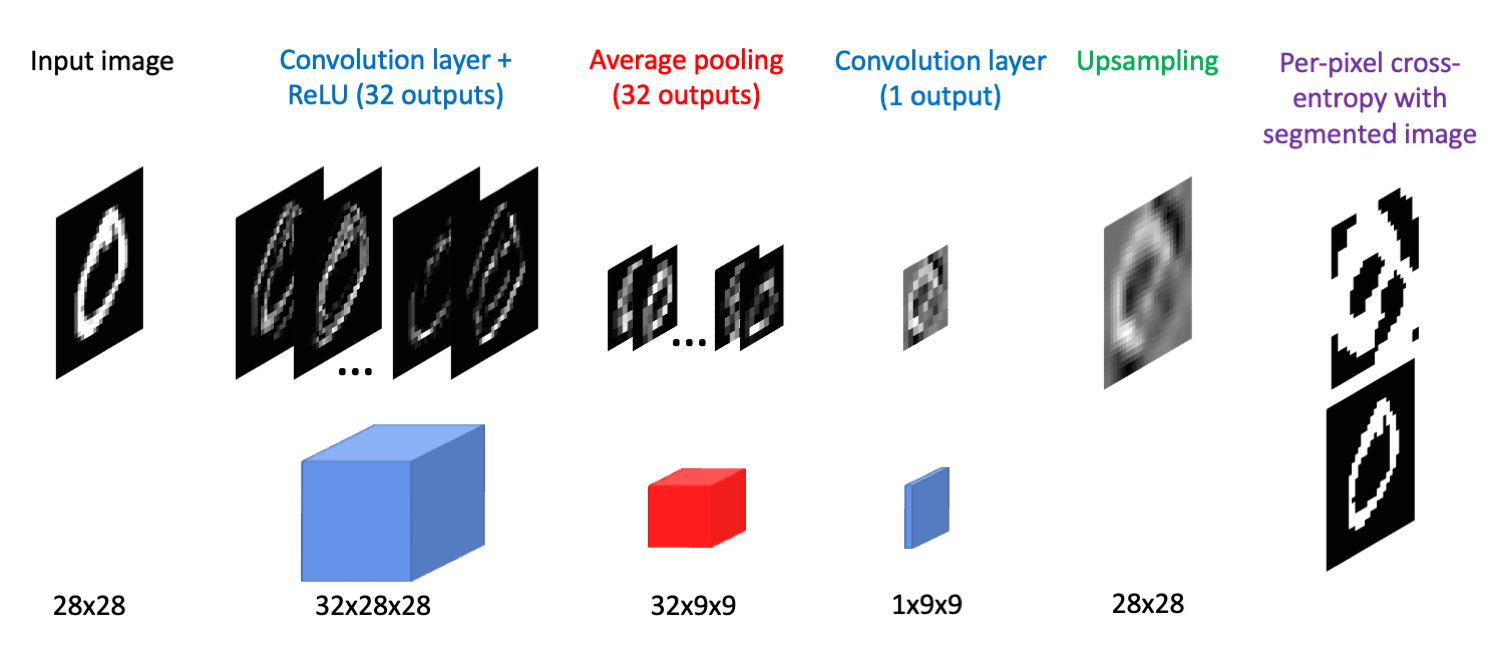

In [103]:
Image('images/conv_network_segment.png', width=900)

### Generation

A completely different example of usage of such networks is generation of images via Generative Adverserial Networks or GANs. In such as case the network is more complex but still uses the same sort of building blocks show above. The basic idea of GANs is to train one network to generate images based on a certain dataset and another network to detect whether the image is real or fake based on the same data. During training, both networks become better: one better at creating fakes and the other at detecting them so that the generated images becomes increasingly realistic.

This is for example very useful for publicity in order to create images with "non-existing" people to avoid any rights of images. It can also be used to create additional images to train another network (for example for segmentation) when data are scarce. However in all these cases, great care has to be taken to avoid the generation of so-called artefacts. Typical examples in the generation of artificial human faces, is the difficulty to preserve symmetry with ear-rings, glasses, eye color etc.

### Super-resolution

Yet another application is the "improvement" of images at different levels. For example an image might be blurred because of movement during acquisition or simply the pixel resolution is bad. Here again networks of the type shown above can be designed to improve images by using pairs of good and bad examples. This sort of technology is used both at the consumer technology level, e.g. in iPhones camera, or in scientific studies for example to improve microscopy images.

## Using a network

You can find many trained networks online. Some come with packages live torchvision, some can be found in online repositories. As long as your input images are similar enough to those used to train a network, you can use it without retraining it. If your images are too different, you can either retrain a network, which can take time and requires a large amount of data, or you can **fine-tune** it, i.e. you start from with the trained weights and slowly adjust them to better match your own data.

Another important topic is the pre-processing of the images. Usually, networks expect images formatted in a certain way on various aspects:
- size: the input images are expected to have NxM pixels or a minimal/maximal size
- channels: the input is expected to be composed of N channels. For example a gray-scale image has 1 channel whereas a natural image has three (RGB, Red, Green, Blue)
- intensity: often pixel intensities are scaled within a certain range. This allows one to re-use the network even if pixel values have a different range by re-scaling them appropriately.

## Practical example

We will use here a pre-trained model for image classification available in the torchivision package. The network is called EfficientNet and is a recent architecture that uses much less parameters than first generation networks like VGG. We need to import the network and specify that we want to use the pre-trained version. The pre-training has been performed on the ImageNet dataset, a large collection of natural images with 1000 categories:

In [104]:
from torchvision.models import efficientnet_b0

eff_net = efficientnet_b0(pretrained=True)

As explained in the [documentation](https://pytorch.org/vision/stable/models.html#classification), the image passed to the network needs to be an RGB image, and each channel needs to be rescaled appropriately. This can be done using the following function which takes a Numpy array as input, normalizes the channels (like we normalized features in classical ML methods) and turns the array into a tensor of appropriate dimensions:

In [105]:
def preproc(image):
    image = skimage.transform.rescale(image,0.2, channel_axis=2)
    image_normalized = (image-np.array([0.485, 0.456, 0.406]))/np.array([[0.229, 0.224, 0.225]])
    image_tensor = torch.tensor(image_normalized, dtype=torch.float32)
    image_tensor = image_tensor.permute(2,0,1)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

In [106]:
import skimage.io
hen_image = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/5/57/Chicken_-_melbourne_show_2005.jpg')

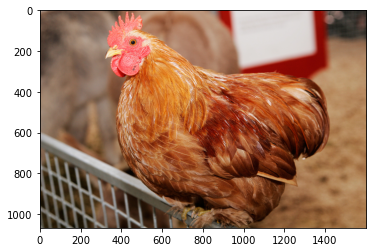

In [107]:
plt.imshow(hen_image);

In [108]:
im_preproc = preproc(hen_image)

In [109]:
eff_net.eval()
categories = eff_net(im_preproc)

In [110]:
categories.shape

torch.Size([1, 1000])

The output is a vector of size 1000 which gives us the probabilities of each category. We just have to find the highest probability and that will be our category but first we load the list of categories corresponding to these indices:

In [111]:
import pandas as pd
cat_names = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt')

Then we sort the probabilities of each category:

In [112]:
sorted_categories, sorted_indices = categories.sort(descending=True)

And we keep the 10 best categories:

In [113]:
cat_names.loc[sorted_indices[0,0:10].detach().numpy()]

,tench
7,hen
8,ostrich
86,African grey
85,partridge
186,Yorkshire terrier
130,little blue heron
9,brambling
519,crib
82,prairie chicken
552,file


We see that the hen comed out on top. Some of the next best hits are a bit strange (like the terrier) but overall it makes sense with many volatiles.

## Exercsise

1. Import one of the networks available in torchivision: https://pytorch.org/vision/stable/models.html#classification 
2. Find a picture on the web and download it to your computer (upload to Colab if necessary)
3. Follow the same steps as above to check the predicted category of your image